In [25]:
import nltk
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import umap
import hdbscan
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

In [26]:
# 2 opciones: 1 como estaba, no visualiza en git, habría que guardar imgs como png y añadir la captura en otra celda
# 2 ponerlo con la config png y kaleido, pero entonces no son interactivas, solo imgs

In [27]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [29]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [31]:
df.shape

(23486, 11)

In [32]:
df = df.dropna().drop_duplicates()

In [33]:
df.shape

(19662, 11)

In [34]:
df = df.reset_index(drop=True)

In [35]:
df['Division Name'].value_counts()

Division Name
General           11664
General Petite     6778
Initmates          1220
Name: count, dtype: int64

In [36]:
df['Department Name'].value_counts()

Department Name
Tops        8713
Dresses     5371
Bottoms     3184
Intimate    1408
Jackets      879
Trend        107
Name: count, dtype: int64

### Preprocess Text

In [37]:
def clean_text(text):
    # Tokenize the text
    tokenized_text = word_tokenize(text)

    # Remove punctuation
    tokenized_text = [word for word in tokenized_text if word not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokenized_text = [word for word in tokenized_text if word not in stop_words]
    
    # Remove tokens that are too short
    tokenized_text = [word for word in tokenized_text if len(word) >= 2]

   # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]

    # Join the words into a single string
    cleaned_text = ' '.join(tokenized_text)
    
    return cleaned_text

In [38]:
df['Review Text'][1]

"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"

In [39]:
df['toks'] = df['Review Text'].apply(clean_text)

### Bertopic Default

In [40]:
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

In [41]:
model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', calculate_probabilities=True,
    verbose=True
)

In [42]:
topics, probs = model.fit_transform(df['toks'])

Batches:   0%|          | 0/615 [00:00<?, ?it/s]

2024-04-09 16:32:58,184 - BERTopic - Transformed documents to Embeddings
2024-04-09 16:33:19,789 - BERTopic - Reduced dimensionality
2024-04-09 16:33:34,606 - BERTopic - Clustered reduced embeddings


In [43]:
freq = model.get_topic_info()
freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8953,-1_dress_size_fit_nt,"[dress, size, fit, nt, love, color, like, look...",[The blue version dress originally caught eye ...
1,0,1149,0_sweater_love sweater_itchy_soft,"[sweater, love sweater, itchy, soft, sleeve, c...",[This sweater look heavy online bit thin sweat...
2,1,989,1_shirt_tshirt_love shirt_love,"[shirt, tshirt, love shirt, love, nt, great, f...",[bought shirt teal/navy loved much went back b...
3,2,768,2_skirt_love skirt_waist_size,"[skirt, love skirt, waist, size, great, fit, l...",[This beautiful skirt exactly pictured color b...
4,3,621,3_jean_pair_stretch_ag,"[jean, pair, stretch, ag, 28, pilcro, 27, deni...",[Love pilcro jean usual size fit nice like ski...
5,4,568,4_cute_love_nt_really,"[cute, love, nt, really, like, boxy, small, fi...",[Really cute top especially back 've tried sev...
6,5,566,5_jacket_coat_love jacket_small,"[jacket, coat, love jacket, small, sleeve, med...",[Saw hanging store cute front back flattering ...
7,6,537,6_blouse_love blouse_size_fit,"[blouse, love blouse, size, fit, nt, fabric, l...",[This blouse run large billow slightly hang bo...
8,7,373,7_pant_love pant_pair_comfortable,"[pant, love pant, pair, comfortable, fit, pant...",[absolutely love pant searching pair linen pan...
9,8,278,8_dress_size_run_large,"[dress, size, run, large, small, dress run, fi...",[This dress absolutely stunning color vibrant ...


In [44]:
freq_df = model.get_topic_info()
print("Number of topics: {}".format( len(freq_df)))

Number of topics: 109


In [45]:
# to get visualizations
import kaleido
import plotly.io as pio
# pio.renderers.default='iframe'
pio.renderers.default = 'svg'
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [46]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

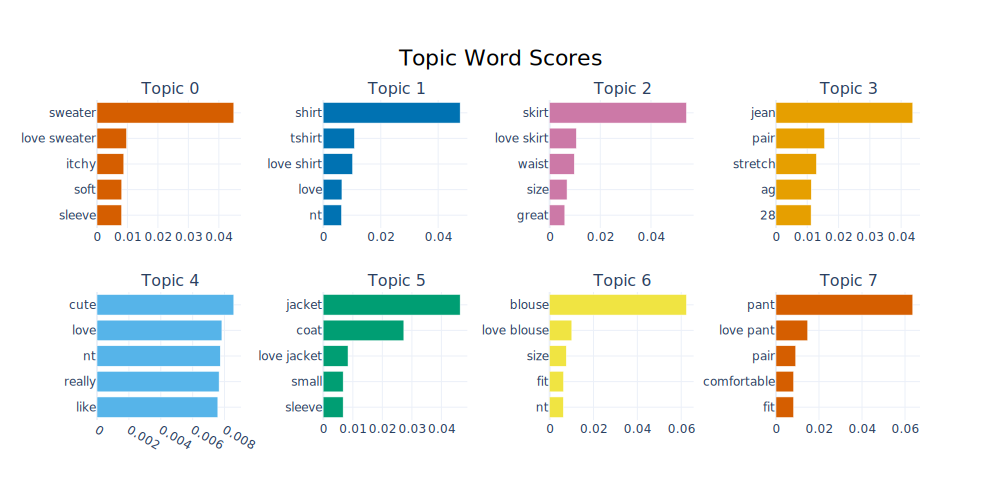

In [47]:
model.visualize_barchart()

### FINE TUNNING BERTOPIC

#### Transformer Embedding

In [48]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [49]:
embedding_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [50]:
sentences_list = df['toks'].tolist()

In [51]:
embeds = embedding_model.encode(sentences_list)

### Dimensionality Reduction UMAP

In [52]:
fit = umap.UMAP(n_neighbors=3, n_components=3, min_dist=0.05)  
u = fit.fit_transform(embeds)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/matplotlib/collections.py:981: RuntimeWarning:

invalid value encountered in sqrt



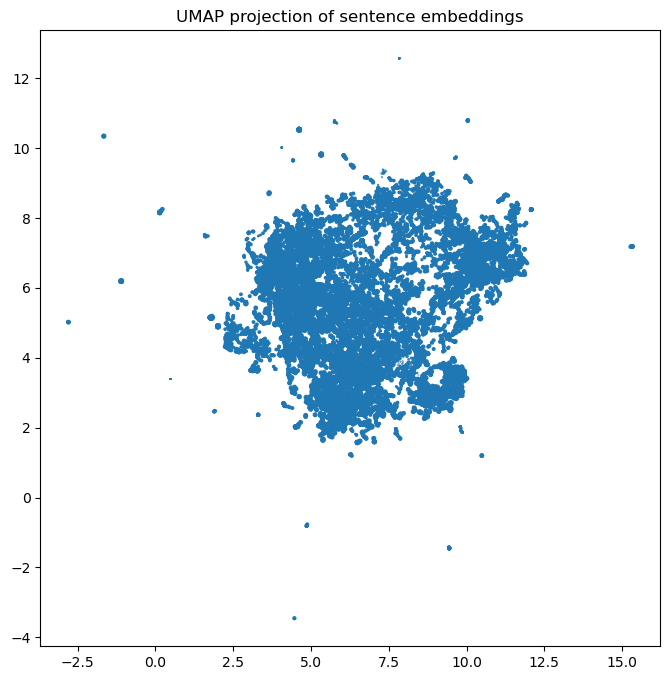

In [53]:
plt.figure(figsize=(8,8)) # Increase figure size
plt.scatter(u[:, 0], u[:, 1], u[:, 2])
plt.title('UMAP projection of sentence embeddings')
plt.show()

### HDBSCAN CLUSTERING

In [54]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=300, gen_min_span_tree=True)
clusterer.fit(u)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=500, min_samples=300)

<AxesSubplot:ylabel='$\\lambda$ value'>

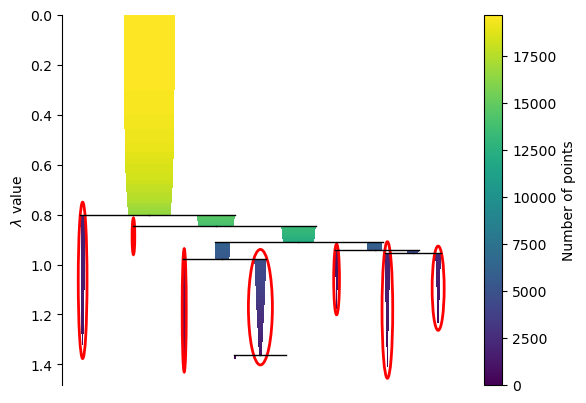

In [55]:
clusterer.condensed_tree_.plot(select_clusters=True)

In [56]:
print(clusterer.relative_validity_)

0.10262129234534505


### FINE TUNED BERTOPIC

In [57]:
umap_model = umap.UMAP(n_components=3, n_neighbors=100, min_dist=0.05)

In [58]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=300, gen_min_span_tree=True, prediction_data=True)

In [59]:
model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)

In [60]:
topics, probs = model.fit_transform(df['toks'])

Batches:   0%|          | 0/615 [00:00<?, ?it/s]

2024-04-09 16:42:49,305 - BERTopic - Transformed documents to Embeddings
2024-04-09 16:43:32,210 - BERTopic - Reduced dimensionality
2024-04-09 16:43:37,185 - BERTopic - Clustered reduced embeddings


In [61]:
freq = model.get_topic_info()
freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8984,-1_size_fit_love_color,"[size, fit, love, color, like]",[Love wearing today longer tunic style denim s...
1,0,3648,0_dress_fit_size_love,"[dress, fit, size, love, like]",[absolutely love dress 's great quality fit pe...
2,1,1811,1_sweater_jacket_love_coat,"[sweater, jacket, love, coat, color]",[saw someone else wearing sweater find 'm '' 1...
3,2,1534,2_pant_jean_fit_pair,"[pant, jean, fit, pair, size]",['ve looking comfortable pant summer pant answ...
4,3,1416,3_love_fit_like_look,"[love, fit, like, look, size]",[Just received bra matching panty mail loved t...
5,4,1134,4_shirt_love_fit_tee,"[shirt, love, fit, tee, color]",[Love shirt style shirt look better person onl...
6,5,629,5_skirt_size_fit_waist,"[skirt, size, fit, waist, love]",[absolutely love way skirt look fit smaller wa...
7,6,506,6_blouse_size_fit_love,"[blouse, size, fit, love, look]",[This blouse run large billow slightly hang bo...


In [62]:
freq_df = model.get_topic_info()
print("Number of topics: {}".format( len(freq_df)))

Number of topics: 8


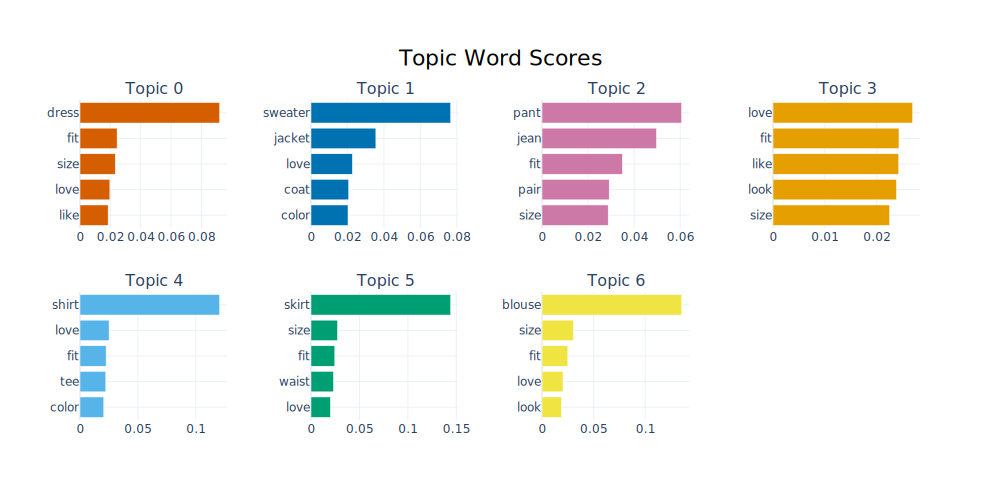

In [63]:
model.visualize_barchart()

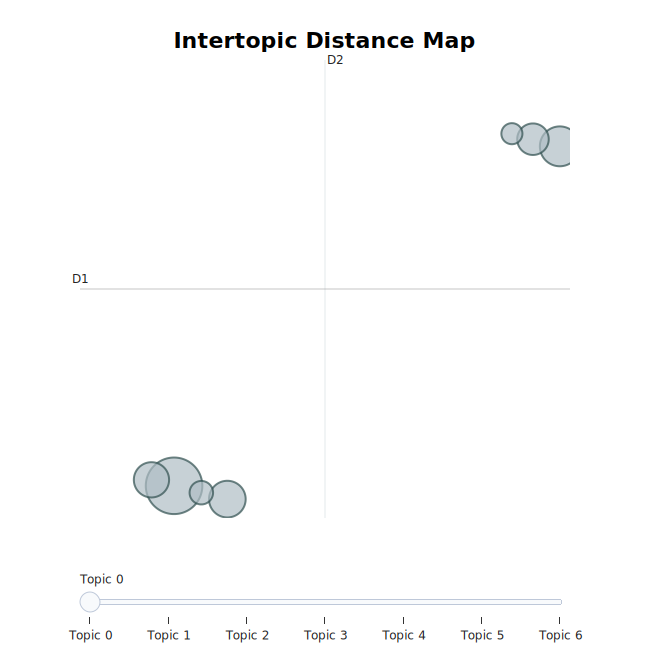

In [64]:
model.visualize_topics()

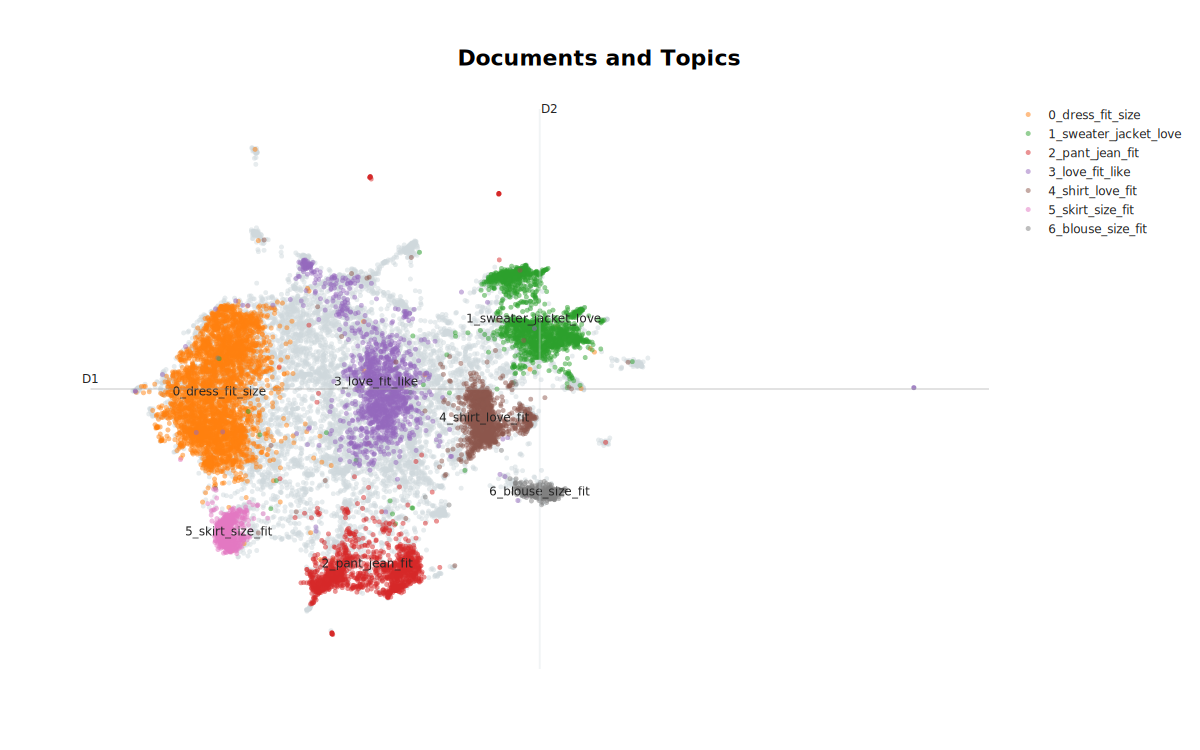

In [65]:
model.visualize_documents(df['toks'], embeddings=embeds)